In [1]:
%cd ..

G:\operation d\active project\const_hw


In [58]:
from imblearn.pipeline import make_pipeline as imblearn_make_pipeline
from imblearn.over_sampling import SMOTE
from src._helper_class import *
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, PoissonRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVC, SVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, average_precision_score, precision_recall_curve

#import warnings
#warnings.filterwarnings('ignore')

In [59]:
import matplotlib.pyplot as plt

In [60]:
# load data
train_data = pd.read_csv("data/dengue_features_train.csv")
train_label = pd.read_csv("data/dengue_labels_train.csv")
test_data = pd.read_csv("data/dengue_features_test.csv")

In [61]:
# classification pipeline
clf_scoring_fsel = 'average_precision'
clf_scoring_tuning = "roc_auc"

clf_pipeline = imblearn_make_pipeline(
    Dengue_cat_encoder(),
    Stationarity_adjustment(),
    Feature_argumentation1(),
    Standardization(),
    Imputer(),
    Feature_argumentation2(),
    Feature_argumentation3(),
    Feature_selection(cv_metric = clf_scoring_fsel,
                      classify_mode = 1),
    SMOTE(),
    General_estimator()
)

clf_parameters = [
    {"general_estimator__estimator": [XGBClassifier(grow_policy = "lossguide",
                                                   objective = "binary:logistic",
                                                   booster = "gbtree",
                                                   tree_method = "hist",
                                                   eta = 0.1
                                                   )
                                     ],
     "feature_selection__estimator": [XGBClassifier(objective = "binary:logistic",
                                                   booster = "gbtree",
                                                   tree_method = "hist")
                                     ],
     "general_estimator__estimator__n_estimators": [5, 8, 11, 14, 17], #[5, 8, 11, 14, 17],
     "general_estimator__estimator__max_leaves": [3, 5, 7, 9], #[3, 5, 7, 9],
     "general_estimator__estimator__min_child_weight": [1, 20],
     "general_estimator__estimator__subsample": [1]
     
    }

]


# regression pipeline

reg_scoring = "r2"

reg_pipeline = imblearn_make_pipeline(
    Dengue_cat_encoder(),
    Stationarity_adjustment(),
    Feature_argumentation1(),
    Standardization(),
    Imputer(),
    Feature_argumentation2(),
    Feature_argumentation3(),
    Feature_selection(),
    General_estimator()
)

reg_parameters = [
    {"general_estimator__estimator": [XGBRegressor(grow_policy = "lossguide",
                                                   objective = "reg:squarederror",
                                                   booster = "gbtree",
                                                   tree_method = "hist",
                                                   eta = 0.1
                                                   )
                                     ],
     "feature_selection__estimator": [XGBRegressor(objective = "reg:squarederror",
                                                   booster = "gbtree",
                                                   tree_method = "hist"
                                                   )
                                     ],
     "general_estimator__estimator__n_estimators": [5, 8, 11, 14, 17],
     "general_estimator__estimator__max_leaves": [3, 5, 7, 9],
     "general_estimator__estimator__min_child_weight": [1],
     "general_estimator__estimator__subsample": [1],
     "general_estimator__severity_mode": [1],

    },
    
    {"general_estimator__estimator": [PoissonRegressor(max_iter = 10000)],
     "feature_selection__estimator": [PoissonRegressor(max_iter = 10000)],
     "general_estimator__estimator__alpha": [1e-1, 1e0, 1e1, 1e2, 1e3],#[1e-1, 1e0, 1e1, 1e2, 1e3],
     "general_estimator__severity_mode": [1]     
    },
    
    {"general_estimator__estimator": [SVR(kernel = 'rbf',
                                          max_iter = 10000)
                                     ],
     "feature_selection__estimator": [SVR(kernel = 'rbf',
                                          max_iter = 10000)
                                     ],
     "general_estimator__estimator__C": [1e-1, 1e0, 1e1, 1e2, 1e3], #[1e-1, 1e0, 1e1, 1e2, 1e3],
     "general_estimator__severity_mode": [1]    
    }

]


In [6]:
def clf_model_fit_transform(city, 
                            threshold, 
                            train_data, 
                            train_label, 
                            test_data, 
                            model_scoring, 
                            model_pipeline, 
                            model_parameters):
    
    train_data = train_data.loc[train_data["city"] == city,:].copy()
    train_data.reset_index(drop = True, inplace = True)
    X = train_data.drop(columns = ["city"])
    
    Y = train_label.loc[train_label["city"] == city,:].copy()
    Y.reset_index(drop = True, inplace = True)
    Y = Y["total_cases"]
    
    Y_threshold = np.percentile(Y, threshold)
    
    Y = (Y >= Y_threshold).astype(int)
    
    test_data = test_data.loc[test_data["city"] == city,:].copy()
    test_data.reset_index(drop = True, inplace = True)
    X_test = test_data.drop(columns = ["city"])
    
    #model_parameters[0]["general_estimator__estimator__scale_pos_weight"] = [len(Y)/Y.sum()]
    
    cv_num = 5
    if city == "iq":
        cv_num = 5

    model_gscv = GridSearchCV(estimator = model_pipeline, 
                              param_grid = model_parameters, 
                              scoring = model_scoring, 
                              cv = cv_num, 
                              verbose = 1,
                              n_jobs = -1,
                              return_train_score = True,
                              error_score = 0)
    
    model_gscv.fit(X, Y)
    
    print("The select parameters:")
    print(list(model_gscv.best_params_.items())[2:])
    
    pred_train = model_gscv.best_estimator_.predict_proba(X)[:,1]
       
    precision, recall, thresholds = precision_recall_curve(Y, pred_train)
    
    threshold_index = np.argmax(precision)
    if threshold_index > len(thresholds) - 1:
        threshold_index -= 1
    cls_threshold = thresholds[threshold_index]
    
    print(cls_threshold)
    
    
    pred_test = model_gscv.best_estimator_.predict_proba(X_test)[:,1]
    
    pred_test = (pred_test >= cls_threshold).astype(int)
    pred_train = (pred_train >= cls_threshold).astype(int)
    
    out_name = str(threshold) + "_cls"
        
    train_data[out_name] = pred_train
    test_data[out_name] = pred_test
    
    return train_data[["city", "week_start_date", out_name]], test_data[["city", "week_start_date", out_name]], model_gscv

def severity_model_fit_transform_v2(city, 
                                 threshold, 
                                 train_data, 
                                 train_label, 
                                 test_data, 
                                 model_scoring, 
                                 model_pipeline, 
                                 model_parameters):
    
    train_data = train_data.loc[train_data["city"] == city,:].copy()
    train_data.reset_index(drop = True, inplace = True)
    X = train_data.drop(columns = ["city"])
    
    Y = train_label.loc[train_label["city"] == city,:].copy()
    Y.reset_index(drop = True, inplace = True)
    Y = Y["total_cases"]
    
    Y_threshold = np.percentile(Y, threshold)
    
    test_data = test_data.loc[test_data["city"] == city,:].copy()
    test_data.reset_index(drop = True, inplace = True)
    X_test = test_data.drop(columns = ["city"])
    
    for i in range(len(model_parameters)):
        model_parameters[i]["general_estimator__threshold"] = [Y_threshold]
           
    model_gscv = GridSearchCV(estimator = model_pipeline, 
                              param_grid = model_parameters, 
                              scoring = model_scoring, 
                              cv = 10, 
                              verbose = 1,
                              n_jobs = -1,
                              return_train_score = True,
                              error_score = Y.mean()+ Y.std())
    

    
    model_gscv.fit(X, Y)
    
    print("The select parameters:")
    print(list(model_gscv.best_params_.items())[2:])
    
    pred_train = model_gscv.best_estimator_.predict(X)
    pred_test = model_gscv.best_estimator_.predict(X_test)
    
    out_name = str(threshold) + "_sev"
    
    train_data[out_name] = pred_train
    test_data[out_name] = pred_test
    
    return train_data[["city", "week_start_date", out_name]], test_data[["city", "week_start_date", out_name]], model_gscv

In [7]:
def two_stage_model_wraper_v2(train_data, 
                              train_label, 
                              test_data, 
                              model_scoring_p, 
                              model_pipeline_p, 
                              model_parameters_p,
                              model_scoring_s, 
                              model_pipeline_s, 
                              model_parameters_s):
    #----------------SJ---------------------------------------------------
    
    temp_sj_data = train_data.loc[train_data["city"] == "sj",:].copy()
    temp_sj_data.reset_index(drop = True, inplace = True)
    
    temp_sj_test = test_data.loc[test_data["city"] == "sj",:].copy()
    temp_sj_test.reset_index(drop = True, inplace = True)
    
    sj_threshold_list = [95, 97]
    
    for threshold in sj_threshold_list:
        print("Fitting SJ data with threshold {}".format(threshold))
        train_cls_sj, test_cls_sj, cv_cls_sj = clf_model_fit_transform("sj",
                                                                        threshold,
                                                                        train_data, 
                                                                        train_label, 
                                                                        test_data, 
                                                                        model_scoring_p,
                                                                        model_pipeline_p,
                                                                        model_parameters_p)
        #print("fitting severity")
        train_sev_sj, test_sev_sj, cv_sev_sj = severity_model_fit_transform_v2("sj",
                                                                            threshold,
                                                                            train_data, 
                                                                            train_label, 
                                                                            test_data, 
                                                                            model_scoring_s,
                                                                            model_pipeline_s,
                                                                            model_parameters_s)
        
        temp_sj_data = temp_sj_data.merge(train_cls_sj, on = ["city", "week_start_date"], how = "left")
        temp_sj_data = temp_sj_data.merge(train_sev_sj, on = ["city", "week_start_date"], how = "left")
        
        temp_sj_test = temp_sj_test.merge(test_cls_sj, on = ["city", "week_start_date"], how = "left")
        temp_sj_test = temp_sj_test.merge(test_sev_sj, on = ["city", "week_start_date"], how = "left")

    
    #----------------IQ---------------------------------------------------
    temp_iq_data = train_data.loc[train_data["city"] == "iq",:].copy()
    temp_iq_data.reset_index(drop = True, inplace = True)
    
    temp_iq_test = test_data.loc[test_data["city"] == "iq",:].copy()
    temp_iq_test.reset_index(drop = True, inplace = True)
    
    iq_threshold_list = [95, 97]
    
    for threshold in iq_threshold_list:
        print("Fitting IQ data with threshold {}".format(threshold))
        train_cls_iq, test_cls_iq, cv_cls_iq = clf_model_fit_transform("iq",
                                                                        threshold,
                                                                        train_data, 
                                                                        train_label, 
                                                                        test_data, 
                                                                        model_scoring_p,
                                                                        model_pipeline_p,
                                                                        model_parameters_p)
        #print("fitting severity")
        train_sev_iq, test_sev_iq, cv_sev_iq = severity_model_fit_transform_v2("iq",
                                                                            threshold,
                                                                            train_data, 
                                                                            train_label, 
                                                                            test_data, 
                                                                            model_scoring_s,
                                                                            model_pipeline_s,
                                                                            model_parameters_s)
        
        temp_iq_data = temp_iq_data.merge(train_cls_iq, on = ["city", "week_start_date"], how = "left")
        temp_iq_data = temp_iq_data.merge(train_sev_iq, on = ["city", "week_start_date"], how = "left")
        
        temp_iq_test = temp_iq_test.merge(test_cls_iq, on = ["city", "week_start_date"], how = "left")
        temp_iq_test = temp_iq_test.merge(test_sev_iq, on = ["city", "week_start_date"], how = "left")
        

    #-----------------------combine results----------------------------------------------------------
    for threshold in sj_threshold_list:
        cls_name = str(threshold) + "_cls"
        sev_name = str(threshold) + "_sev"
        temp_sj_data.loc[:, [str(threshold)]] = temp_sj_data[[cls_name]].to_numpy() * temp_sj_data[[sev_name]].to_numpy()
        temp_sj_test.loc[:, [str(threshold)]] = temp_sj_test[[cls_name]].to_numpy() * temp_sj_test[[sev_name]].to_numpy()
    
    sj_pred_train = temp_sj_data.iloc[:,-2:].max(axis=1)
    sj_pred_test = temp_sj_test.iloc[:,-2:].max(axis=1)
    #sj_pred_train = temp_sj_data.loc[:,str(threshold)]
    #sj_pred_test = temp_sj_data.loc[:,str(threshold)]
    

    for threshold in iq_threshold_list:
        cls_name = str(threshold) + "_cls"
        sev_name = str(threshold) + "_sev"
        temp_iq_data.loc[:, [str(threshold)]] = temp_iq_data[[cls_name]].to_numpy() * temp_iq_data[[sev_name]].to_numpy()
        temp_iq_test.loc[:, [str(threshold)]] = temp_iq_test[[cls_name]].to_numpy() * temp_iq_test[[sev_name]].to_numpy()
    
    iq_pred_train = temp_iq_data.iloc[:,-2:].max(axis=1)
    iq_pred_test = temp_iq_test.iloc[:,-2:].max(axis=1)    
    #iq_pred_train = temp_iq_data.loc[:,str(threshold)]
    #iq_pred_test = temp_iq_test.loc[:,str(threshold)]
    
    train_pred = pd.concat([sj_pred_train, iq_pred_train], ignore_index = True)
    test_pred = pd.concat([sj_pred_test, iq_pred_test], ignore_index = True)
    
    
    #
    out_train = train_data.copy()
    out_train["prediction"] = train_pred.astype(int)
    out_test = test_data.copy()
    out_test["prediction"] = test_pred.astype(int)
       
    current_score = mean_absolute_error(train_label["total_cases"], out_train["prediction"])
    print("Train MAE: {}".format(current_score))
          
    out_train = out_train[["city", "year", "weekofyear", "week_start_date", "prediction"]]
    out_test = out_test[["city", "year", "weekofyear", "prediction"]]
    
    return out_train, out_test

In [8]:
train_pred, test_pred = two_stage_model_wraper_v2(train_data, 
                                               train_label, 
                                               test_data,
                                               clf_scoring_tuning,
                                               clf_pipeline,
                                               clf_parameters,
                                               reg_scoring, 
                                               reg_pipeline, 
                                               reg_parameters)

Fitting SJ data with threshold 95
Fitting 5 folds for each of 40 candidates, totalling 200 fits


E:\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:253: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  ConvergenceWarning,
E:\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:253: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  ConvergenceWarning,


The select parameters:
[('general_estimator__estimator__max_leaves', 3), ('general_estimator__estimator__min_child_weight', 1), ('general_estimator__estimator__n_estimators', 11), ('general_estimator__estimator__subsample', 1)]
0.6857788
Fitting 10 folds for each of 30 candidates, totalling 300 fits


E:\Anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The select parameters:
[('general_estimator__estimator__max_leaves', 7), ('general_estimator__estimator__min_child_weight', 1), ('general_estimator__estimator__n_estimators', 5), ('general_estimator__estimator__subsample', 1), ('general_estimator__severity_mode', 1), ('general_estimator__threshold', 112.0)]
Fitting SJ data with threshold 97
Fitting 5 folds for each of 40 candidates, totalling 200 fits
The select parameters:
[('general_estimator__estimator__max_leaves', 9), ('general_estimator__estimator__min_child_weight', 1), ('general_estimator__estimator__n_estimators', 5), ('general_estimator__estimator__subsample', 1)]
0.65659
Fitting 10 folds for each of 30 candidates, totalling 300 fits


E:\Anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The select parameters:
[('general_estimator__estimator__max_leaves', 5), ('general_estimator__estimator__min_child_weight', 1), ('general_estimator__estimator__n_estimators', 5), ('general_estimator__estimator__subsample', 1), ('general_estimator__severity_mode', 1), ('general_estimator__threshold', 140.94999999999993)]
Fitting IQ data with threshold 95
Fitting 5 folds for each of 40 candidates, totalling 200 fits
The select parameters:
[('general_estimator__estimator__max_leaves', 3), ('general_estimator__estimator__min_child_weight', 20), ('general_estimator__estimator__n_estimators', 11), ('general_estimator__estimator__subsample', 1)]
0.766734
Fitting 10 folds for each of 30 candidates, totalling 300 fits


E:\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:253: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  ConvergenceWarning,
E:\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:253: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  ConvergenceWarning,
E:\Anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The select parameters:
[('general_estimator__estimator__max_leaves', 7), ('general_estimator__estimator__min_child_weight', 1), ('general_estimator__estimator__n_estimators', 5), ('general_estimator__estimator__subsample', 1), ('general_estimator__severity_mode', 1), ('general_estimator__threshold', 28.0)]
Fitting IQ data with threshold 97
Fitting 5 folds for each of 40 candidates, totalling 200 fits


E:\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:253: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  ConvergenceWarning,


The select parameters:
[('general_estimator__estimator__max_leaves', 5), ('general_estimator__estimator__min_child_weight', 20), ('general_estimator__estimator__n_estimators', 17), ('general_estimator__estimator__subsample', 1)]
0.88306034
Fitting 10 folds for each of 30 candidates, totalling 300 fits


E:\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:253: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  ConvergenceWarning,
E:\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:253: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  ConvergenceWarning,
E:\Anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The select parameters:
[('general_estimator__estimator__max_leaves', 3), ('general_estimator__estimator__min_child_weight', 1), ('general_estimator__estimator__n_estimators', 5), ('general_estimator__estimator__subsample', 1), ('general_estimator__severity_mode', 1), ('general_estimator__threshold', 33.43000000000001)]
Train MAE: 22.81662087912088


<AxesSubplot:>

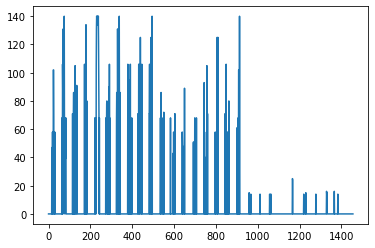

In [9]:
train_pred["prediction"].plot()

<AxesSubplot:>

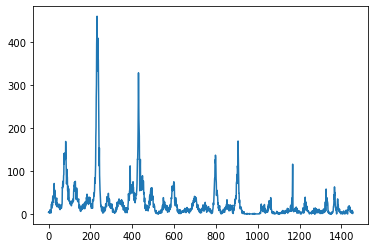

In [10]:
train_label["total_cases"].plot()

<AxesSubplot:>

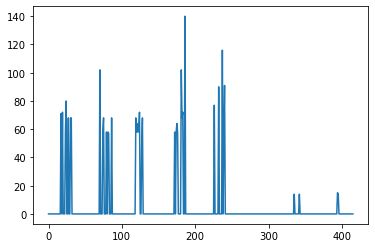

In [11]:
test_pred["prediction"].plot()

In [12]:
train_pred.to_csv("twostage_outlier_train_pred.csv", index = False)
test_pred.to_csv("twostage_outlier_test_pred.csv", index = False)

submission = pd.read_csv("data/submission_format.csv")
submission = submission.merge(test_pred, on = ["city", "year", "weekofyear"], how = "left")
submission["total_cases"] = submission["prediction"].astype(int)
submission.drop(columns=["prediction"], inplace = True)

submission.to_csv("twostage_outlier_submission.csv", index = False)

In [48]:
one_stage_prediction = pd.read_csv("onestage_submission.csv")
lstm_prediction = pd.read_csv("lstm_prediction.csv")

In [49]:
test_pred_rev_mask = (test_pred["prediction"]>0).astype(int)
test_pred_rev_mask = 1 - test_pred_rev_mask

In [50]:
one_stage_prediction["total_cases"] = test_pred_rev_mask*one_stage_prediction.loc[:,"total_cases"].to_numpy() + test_pred.loc[:, "prediction"].to_numpy()

In [51]:
lstm_prediction["total_cases"] = test_pred_rev_mask*lstm_prediction.loc[:,"total_cases"].to_numpy() + test_pred.loc[:, "prediction"].to_numpy()

In [56]:
lstm_prediction["total_cases"] = lstm_prediction["total_cases"].astype(int)

In [57]:
one_stage_prediction.to_csv("twostage_onestage_submission.csv", index = False)
lstm_prediction.to_csv("twostage_lstm_submission.csv", index = False)